In [6]:
import numpy as np
import pandas as pd
from collections import defaultdict
from math import radians, sin, cos, sqrt, atan2
import re
from collections import Counter
from scipy.stats import zscore
from pathlib import Path

from sklearn.model_selection import GroupKFold
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import joblib
from sklearn.ensemble import IsolationForest
from collections import defaultdict, Counter
import hashlib
import ast
from typing import Optional, Dict, Tuple



gt = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/gt/anomalous_temporal.csv')

In [3]:
train = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/10k/ore/or_train.csv')
test = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/10k/ore/or_test.csv')

# TRAIN_DIR = Path("/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/2m/ore/stop_past")
# TEST_DIR  = Path("/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/2m/ore/stop_future")


# def bucket_id_from_path(p: Path) -> int:
#     return int(p.name.split("agent_bucket=")[1].split(".csv")[0])

# train_files = {bucket_id_from_path(p): p for p in TRAIN_DIR.glob("agent_bucket=*.csv")}
# test_files  = {bucket_id_from_path(p): p for p in TEST_DIR.glob("agent_bucket=*.csv")}
# common_buckets = sorted(set(train_files).intersection(test_files))

# #all_train_list = []
# all_test_list = []

# for b in common_buckets:
#     #train_path = train_files[b]
#     test_path  = test_files[b]

#     print(f"=== Processing bucket {b} ===")
    
#     #train_data = pd.read_csv(train_path)
#     test_data  = pd.read_csv(test_path)
    
#     #all_train_list.append(train_data)
#     all_test_list.append(test_data)

# #train = pd.concat(all_train_list, ignore_index=True)
# test = pd.concat(all_test_list, ignore_index=True)

test['started_at']  = pd.to_datetime(test['started_at'])
test['finished_at'] = pd.to_datetime(test['finished_at'])

train['started_at']  = pd.to_datetime(train['started_at'])
train['finished_at'] = pd.to_datetime(train['finished_at'])

gt['started_at'] = pd.to_datetime(gt['started_at']) 
gt['started_at'] = gt['started_at'].dt.tz_convert('Asia/Tokyo')
gt['finished_at'] = pd.to_datetime(gt['finished_at']) 
gt['finished_at'] = gt['finished_at'].dt.tz_convert('Asia/Tokyo')

# # adding ground truth
train['label'] = 0
test['label'] = 0

for agent, gt_agent in gt.groupby('agent'):
    agent_mask = test['agent'] == agent

    if not agent_mask.any():
        continue

    for _, row in gt_agent.iterrows():
        anomaly_start_time = row['started_at']
        anomaly_end_time   = row['finished_at']

        overlap_mask = (
            agent_mask &
            (test['started_at'] < anomaly_end_time) &
            (test['finished_at'] > anomaly_start_time)
        )

        test.loc[overlap_mask, 'label'] = 1

In [19]:
def _to_locset(x):
    """
    Convert transformation / transformation_str into a Python set of tokens.
    Handles:
      - list of ints/strings
      - stringified list like "[1,2,3]"
      - comma-separated strings "1,2,3"
      - None/NaN
    """
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return set()
    if isinstance(x, (list, tuple)):
        return set(x)

    if isinstance(x, str):
        s = x.strip()
        if not s:
            return set()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                v = ast.literal_eval(s)
                if isinstance(v, (list, tuple)):
                    return set(v)
            except Exception:
                pass

        if "," in s:
            return set(t.strip() for t in s.split(",") if t.strip())
        return {s}

    return set([str(x)])


def score_max_outlier_by_poi(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    *,
    use_transformation_jaccard: bool = True,
    weights: Optional[Dict[str, float]] = None,
    return_row_level: bool = False,
) -> pd.DataFrame:
    """
    For each test row, find the most similar train row among SAME agent + SAME dominant_poi.
    Score(test_row) = min distance across those candidates.
    Agent score = max Score(test_row) across that agent's test rows.

    If no train rows exist for (agent, dominant_poi), fallback to all train rows for that agent.

    Returns:
      - by default: DataFrame [agent, anomaly_score]
      - if return_row_level: DataFrame with per-test-row min_score + chosen match source
    """

    if weights is None:
        weights = {
            "duration_min": 0.9954,
            "max_distance_from_home": 1.0792,
            "avg_speed_first_half": 0.0466,
            "avg_speed_second_half": 0.3712,
            # optional transformation dissimilarity
            "trans_jaccard": -0.3132,  # this is added ON TOP
        }

    train = train_df.copy()
    test = test_df.copy()

    for col in ["agent", "dominant_poi"]:
        if col not in train.columns or col not in test.columns:
            raise ValueError(f"Missing required column: {col}")

    train["dominant_poi"] = train["dominant_poi"].astype(str)
    test["dominant_poi"] = test["dominant_poi"].astype(str)

    test = test.reset_index(drop=True)
    test["test_row_id"] = np.arange(len(test), dtype=np.int64)

    numeric_cols = [
        c for c in ["duration_min", "max_distance_from_home", "avg_speed_first_half", "avg_speed_second_half"]
        if c in train.columns and c in test.columns
    ]
    if not numeric_cols:
        raise ValueError("No numeric feature columns found in both train and test.")

    pairs_poi = test.merge(
        train,
        on=["agent", "dominant_poi"],
        how="inner",
        suffixes=("_test", "_train"),
    )

    matched_ids = set(pairs_poi["test_row_id"].unique()) if not pairs_poi.empty else set()
    missing_test = test[~test["test_row_id"].isin(matched_ids)]

    pairs_agent = pd.DataFrame()
    if not missing_test.empty:
        pairs_agent = missing_test.merge(
            train,
            on=["agent"],
            how="inner",
            suffixes=("_test", "_train"),
        )
    
        if not pairs_agent.empty:
            pairs_agent["match_source"] = "agent_fallback"

    if not pairs_poi.empty:
        pairs_poi["match_source"] = "poi_match"

    # Combine
    if pairs_poi.empty and pairs_agent.empty:
        # no train overlap at all (weird)
        out = test[["agent"]].drop_duplicates().copy()
        out["anomaly_score"] = np.nan
        return out

    pairs = pd.concat([pairs_poi, pairs_agent], ignore_index=True)

    # Numeric distance (weighted L1)
    total = np.zeros(len(pairs), dtype=np.float32)
    for c in numeric_cols:
        w = float(weights.get(c, 0.0))
        if w == 0.0:
            continue
        a = pd.to_numeric(pairs[f"{c}_test"], errors="coerce").to_numpy(dtype=np.float32)
        b = pd.to_numeric(pairs[f"{c}_train"], errors="coerce").to_numpy(dtype=np.float32)
        diff = np.abs(np.nan_to_num(a, nan=0.0) - np.nan_to_num(b, nan=0.0))
        total += (w * diff).astype(np.float32)

    # Optional transformation similarity penalty via (1 - Jaccard)
    # NOTE: This part is Python-loop-ish, but only over merged candidate pairs.
    # If your merge explodes (huge pairs), you must cap candidates (see note below).
    if use_transformation_jaccard:
        # pick a transformation column
        tcol = "transformation"
        if tcol not in pairs.columns:
            tcol = "transformation_str" if "transformation_str" in pairs.columns else None

        if tcol is not None:
            wj = float(weights.get("trans_jaccard", 0.0))
            if wj != 0.0:
                t_test = pairs[f"{tcol}_test"].tolist()
                t_train = pairs[f"{tcol}_train"].tolist()

                jac_pen = np.empty(len(pairs), dtype=np.float32)
                for i, (xt, xr) in enumerate(zip(t_test, t_train)):
                    st = _to_locset(xt)
                    sr = _to_locset(xr)
                    if not st and not sr:
                        jac_pen[i] = 0.0
                        continue
                    inter = len(st & sr)
                    uni = len(st | sr)
                    jac = inter / uni if uni else 0.0
                    jac_pen[i] = 1.0 - jac  # penalty: higher = more different

                total += (wj * jac_pen).astype(np.float32)

    pairs["pair_score"] = total

    # For each test row: keep min (most similar train row)
    min_per_test = pairs.groupby("test_row_id", sort=False)["pair_score"].min()

    # If you want row-level details, return those
    if return_row_level:
        row_level = (
            min_per_test.to_frame("min_score")
            .join(test.set_index("test_row_id")[["agent", "dominant_poi"]], how="left")
            .reset_index()
        )
        # Agent max outlier too
        agent_level = row_level.groupby("agent", sort=False)["min_score"].max().reset_index()
        agent_level.rename(columns={"min_score": "anomaly_score"}, inplace=True)
        return row_level, agent_level

    # Agent score = max outlier across its test rows
    tmp = (
        min_per_test.to_frame("min_score")
        .join(test.set_index("test_row_id")["agent"], how="left")
    )
    out = tmp.groupby("agent", sort=False)["min_score"].max().reset_index()
    out.rename(columns={"min_score": "anomaly_score"}, inplace=True)
    return out

In [20]:
scores = score_max_outlier_by_poi(
    train_df=train,
    test_df=test,
)

In [21]:
scores.rename(columns={'anomaly_score': 'agent_anomaly_score'}, inplace=True)

In [24]:
scores

,agent,agent_anomaly_score
0,421,155.185226
1,431,270.176941
2,617,1460.097656
3,889,121.088234
4,1640,36.836143
...,...,...
8865,1999530,33.234489
8866,1999601,275.949280
8867,1999642,299.819824
8868,1999875,53.595367


### Gradient boosing

In [14]:
def add_features(df):
    df = df.copy()
    
    df['start_minute'] = df['started_at'].dt.hour * 60 + df['started_at'].dt.minute
    
    def _len_trans(x):
        if isinstance(x, (list, tuple)):
            return len(x)
        try:
            return len(eval(x))
        except:
            return np.nan
    
    df['len_trans'] = df['transformation'].apply(_len_trans)
    df['speed_imbalance'] = (df['avg_speed_first_half'] - df['avg_speed_second_half']).abs()
    
    return df


def supervised_anomaly_scoring(test_df):
    test = add_features(test_df)

    test = pd.get_dummies(test, columns=['dominant_poi'], prefix='poi')
    
    # Dynamically find the new POI columns
    poi_cols = [c for c in test.columns if c.startswith('poi_')]
    
    base_features = [
        'duration_min', 'start_minute', 'len_trans',
        'max_distance_from_home', 'avg_speed_first_half',
        'avg_speed_second_half', 'speed_imbalance'
    ]

    feature_cols = base_features + poi_cols

    X = test[feature_cols].fillna(0.0)
    y = test['label'].values
    groups = test['agent'].values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    gkf = GroupKFold(n_splits=5)

    preds = np.zeros(len(test))
    model = GradientBoostingClassifier()

    model.fit(X, y)

    preds[:] = model.predict_proba(X)[:, 1]

    test['anomaly_score_row'] = preds

    ap = average_precision_score(y, preds)
    print(f"Out-of-fold Average Precision = {ap:.4f}")

    agent_scores = (
        test.groupby('agent')['anomaly_score_row']
            .max()
            .reset_index(name='agent_anomaly_score')
    )

    return agent_scores, test, model, scaler, feature_cols


In [15]:
agent_scores, test_scored, model, scaler, feature_cols = supervised_anomaly_scoring(test)

: 

In [12]:
joblib.dump(
    {
        "model": model,
        "scaler": scaler,
        "feature_cols": feature_cols,
    },
    "gb_anomaly_bundle.joblib"
)

['gb_anomaly_bundle.joblib']

In [55]:
agent_scores.to_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/10k/ore.csv', index=False)

### Results

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
import matplotlib.pyplot as plt

def plot_agent_level_pr_roc(agent_scores, gt):
    scores = agent_scores.copy()

    # Create ground truth binary label
    scores['label'] = scores['agent'].isin(gt['agent']).astype(int)

    y_true = scores['label'].values
    y_score = scores['agent_anomaly_score'].values

    # ---------- Precision Recall ----------
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    # ---------- ROC ----------
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    # ---------- Plot ----------
    plt.figure(figsize=(12,5))

    # PR Curve
    plt.subplot(1,2,1)
    plt.plot(recall, precision, linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve (AP = {ap:.4f})")
    plt.grid(alpha=0.3)

    # ROC Curve
    plt.subplot(1,2,2)
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"Average Precision: {ap:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return scores


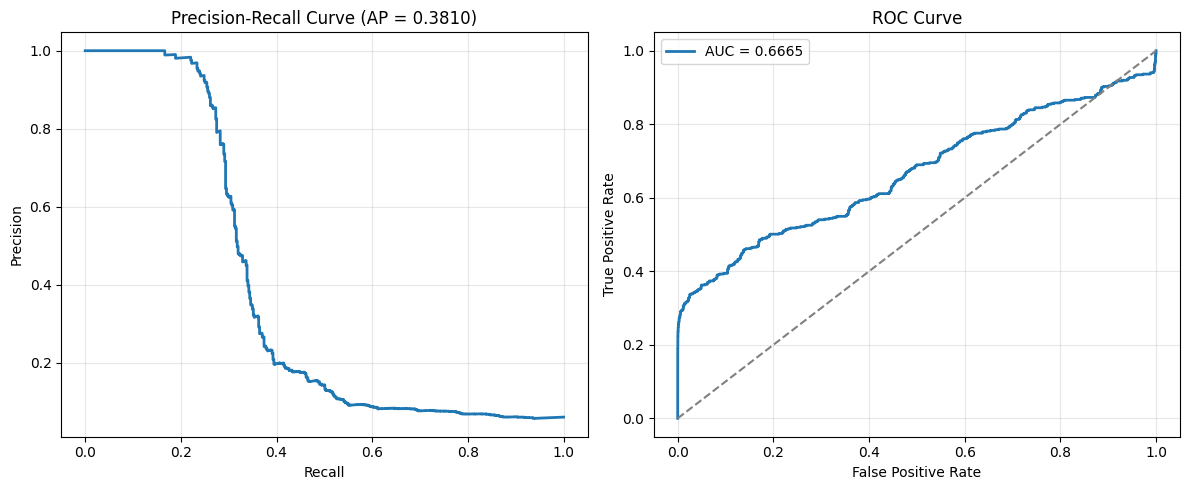

Average Precision: 0.3810
ROC-AUC: 0.6665


In [23]:
evaluated = plot_agent_level_pr_roc(scores, gt)

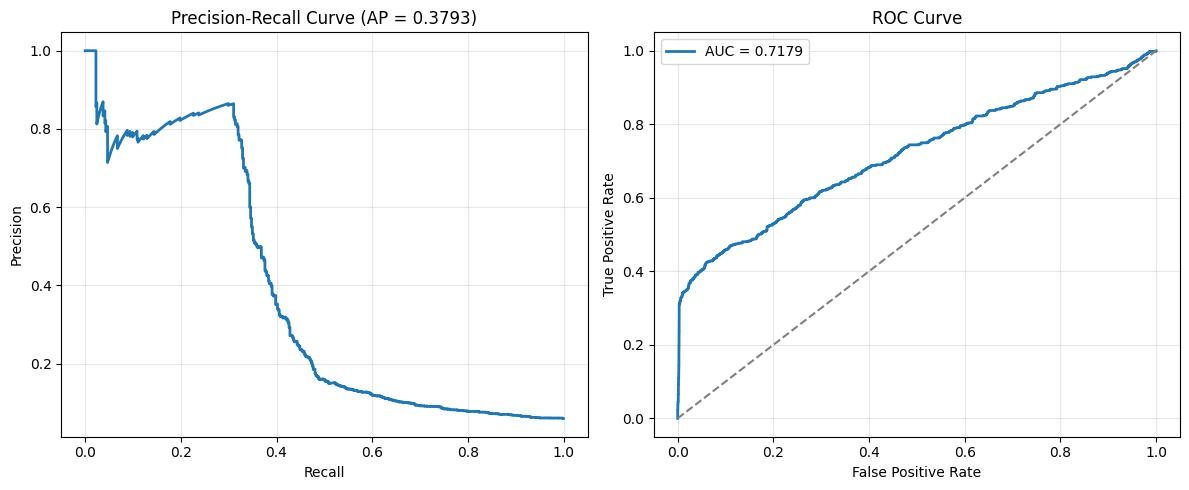

Average Precision: 0.3793
ROC-AUC: 0.7179


In [23]:
evaluated = plot_agent_level_pr_roc(agent_scores, gt)

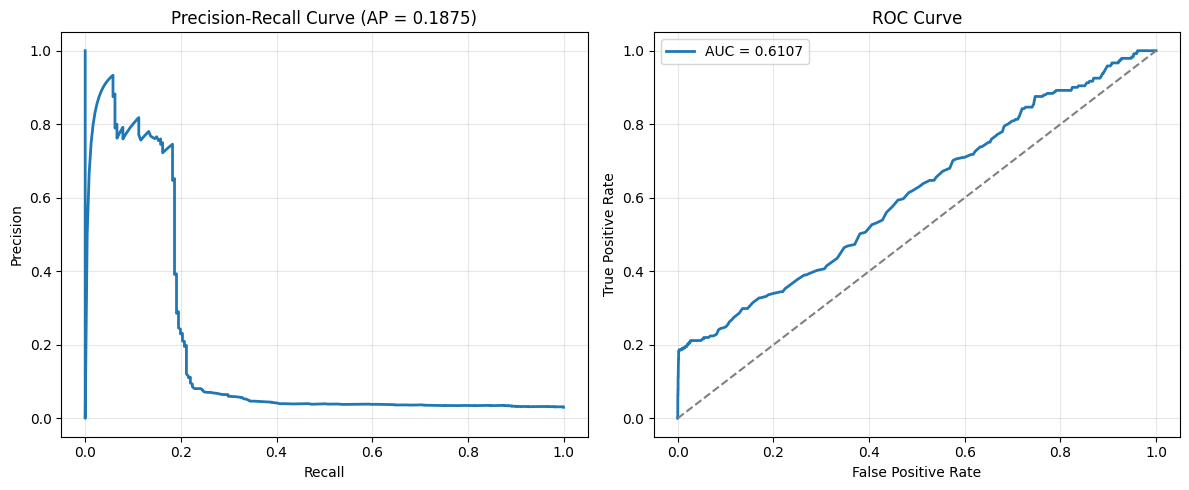

Average Precision: 0.1875
ROC-AUC: 0.6107


In [134]:
evaluated = plot_agent_level_pr_roc(agent_scores, gt)

In [123]:
# Analyze top 10% highest anomaly scores
TOP_FRACTION = 0.01
num_agents = len(agent_scores)
top_n = max(1, int(np.ceil(num_agents * TOP_FRACTION)))

print(f"Total agents: {num_agents}")
print(f"Selecting top {TOP_FRACTION:.0%} => {top_n} agents with highest composite scores")

# Select top agents by composite anomaly score
anomaly_df_sorted = agent_scores.sort_values('agent_anomaly_score', ascending=False)
top_agents = anomaly_df_sorted.head(top_n).copy()

# Check how many are in ground truth
top_agents['is_ground_truth'] = top_agents['agent'].isin(ground_truth['agent'])
num_gt_in_top = top_agents['is_ground_truth'].sum()

print(f"Ground truth anomalies within top {TOP_FRACTION:.0%}: {num_gt_in_top}")
print(f"Percentage of top {TOP_FRACTION:.0%} that are ground truth: {num_gt_in_top / top_n:.2%}")
#print(f"Share of all ground truth anomalies captured: {num_gt_in_top / agent_scores['is_anomaly'].sum():.2%}")

top_agents[['agent', 'agent_anomaly_score', 'is_ground_truth']].head(20)


Total agents: 7953
Selecting top 1% => 80 agents with highest composite scores
Ground truth anomalies within top 1%: 53
Percentage of top 1% that are ground truth: 66.25%


,agent,agent_anomaly_score,is_ground_truth
7342,736011,1.0,True
1220,127678,1.0,True
7673,771653,1.0,False
3289,332749,1.0,False
5416,541287,1.0,True
5608,562025,1.0,True
2060,212229,1.0,True
2954,300767,1.0,True
2956,300980,1.0,True
7643,767556,1.0,True


In [139]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

def calculate_supervised_anomaly_scores(train_df, test_df):
    def get_features(df, profiles=None, is_train_set=False):
        # 1. Basic Preprocessing
        df = df.copy()
        df['start_min'] = pd.to_datetime(df['started_at']).dt.hour * 60 + pd.to_datetime(df['started_at']).dt.minute
        df['trans_tuple'] = df['transformation'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
        df['trans_len'] = df['transformation'].apply(len)
        df['speed_diff'] = (df['avg_speed_first_half'] - df['avg_speed_second_half']).abs()

        # 2. Build or Apply Agent Profiles
        if is_train_set:
            # Create profiles from the training data only
            profiles = df.groupby('agent').agg(
                avg_dur=('duration_min', 'mean'),
                avg_start=('start_min', 'mean'),
                max_dist_hist=('max_distance_from_home', 'max'),
                known_trans=('trans_tuple', lambda x: set(x)),
                known_pois=('dominant_poi', lambda x: set(x))
            ).reset_index()
            return profiles

        # 3. Join profiles to the dataframe to calculate "Deltas"
        data = df.merge(profiles, on='agent', how='left')
        
        # 4. Feature Engineering: Deviations from their own "Normal"
        features = pd.DataFrame()
        features['agent'] = data['agent'] # Keep for grouping later
        
        # Temporal Deltas
        features['delta_duration'] = (data['duration_min'] - data['avg_dur']).abs()
        features['delta_start'] = (data['start_min'] - data['avg_start']).abs()
        
        # Structural Novelty (Binary/Categorical)
        #features['is_new_transformation'] = data.apply(lambda r: 1 if r['trans_tuple'] not in r['known_trans'] else 0, axis=1)
        #features['is_new_poi'] = data.apply(lambda r: 1 if r['dominant_poi'] not in r['known_pois'] else 0, axis=1)
        
        # Numerical magnitude
        features['dist_vs_max'] = data['max_distance_from_home'] / (data['max_dist_hist'] + 1e-5)
        features['speed_imbalance'] = data['speed_diff']
        features['max_distance'] = data['max_distance_from_home']
        features['trans_len'] = data['trans_len']
        
        return features, data['label']

    # --- Execution ---
    
    # 1. Learn "Normal" from Train Data
    agent_profiles = get_features(train_df, is_train_set=True)
    
    # 2. Extract features for Test Data based on Train Profiles
    X, y = get_features(test_df, profiles=agent_profiles, is_train_set=False)
    
    # Prepare X for ML (drop agent ID)
    X_ml = X.drop(columns=['agent']).fillna(0)
    
    # 3. Train Model (Using Cross-Validation to get scores for all test rows)
    # We use a Classifier because we have labels (0 and 1)
    clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    
    # To get a score for every row without over-fitting, use Out-of-Fold predictions
    skf = StratifiedKFold(n_splits=5)
    test_df['row_score'] = 0.0
    
    for train_idx, val_idx in skf.split(X_ml, y):
        X_train_fold, y_train_fold = X_ml.iloc[train_idx], y.iloc[train_idx]
        X_val_fold = X_ml.iloc[val_idx]
        
        clf.fit(X_train_fold, y_train_fold)
        # Probability of being class 1 is our anomaly score
        test_df.loc[val_idx, 'row_score'] = clf.predict_proba(X_val_fold)[:, 1]

    # 4. Aggregate to Agent Level
    agent_scores = test_df.groupby('agent').agg(
        mean_anomaly_prob=('row_score', 'mean'),
        max_anomaly_prob=('row_score', 'max'),
        total_anomalies_detected=('label', 'sum') # Ground truth count
    ).reset_index()
    
    # Final Ranking Score
    agent_scores['final_score'] = (agent_scores['mean_anomaly_prob'] * 0.4) + (agent_scores['max_anomaly_prob'] * 0.6)
    
    return agent_scores.sort_values(by='final_score', ascending=False)

In [140]:
result_df = calculate_supervised_anomaly_scores(train, test)

In [ ]:
agent_scores